Experiment 5:
Timestep Reduction to the mean of 2 consecutive hours and timesteps of 24 steps

Network: LSTM

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Loading necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import warnings

# Ignore warnings
warnings.filterwarnings('ignore')
np.set_printoptions(threshold=np.inf, precision=2, linewidth=200)
np.set_printoptions(suppress=True, precision=2)

As a first step, we load the raw data from our source.

In [ ]:
# Defining the source path
route_folder = "/content/drive/My Drive/Centro de Transporte/Francisco/2023/Abril 2024/"

# Loading the tensor
tensor = np.load(route_folder+'tensor.npy')
# 110 original coordinates
ori_coords = pd.read_csv(route_folder+'ori_coords.csv')

Now, we are going to reduce our time steps by averaging over consecutive 3-hour intervals.

In [ ]:
if tensor.shape[0] % 2 == 0:
    tensor_reshaped = tensor.reshape(-1, 2, tensor.shape[1], tensor.shape[2])
    tensor_new = tensor_reshaped.mean(axis=1)

In [ ]:
tensor_new.shape

(942, 44, 15)

Now that we have preprocessed our matrices, we will apply min-max scaling normalization to all our steps

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))

tensor_reshaped = tensor_new.reshape(-1, 15)
scaled_tensor = scaler.fit_transform(tensor_reshaped)
scaled_tensor = scaled_tensor.reshape(-1, 44, 15)

Now that we have normalized our tensor, we divide it into training, validation, and testing sets.

In [ ]:
train_percent = 0.7
val_percent = 0.15
test_percent = 0.15

total_examples = scaled_tensor.shape[0]
num_train_examples = int(total_examples * train_percent)
num_val_examples = int(total_examples * val_percent)
num_test_examples = total_examples - num_train_examples - num_val_examples

train_tensor = scaled_tensor[:num_train_examples]
val_tensor = scaled_tensor[num_train_examples:num_train_examples+num_val_examples]
test_tensor = scaled_tensor[num_train_examples+num_val_examples:]

# Add a final dimension of 1 channel; this is necessary to feed it into our network
train_tensor = train_tensor.reshape((train_tensor.shape[0], train_tensor.shape[1], train_tensor.shape[2], 1))
val_tensor = val_tensor.reshape((val_tensor.shape[0], val_tensor.shape[1], val_tensor.shape[2], 1))
test_tensor = test_tensor.reshape((test_tensor.shape[0], test_tensor.shape[1], test_tensor.shape[2], 1))

print(train_tensor.shape, val_tensor.shape, test_tensor.shape)

(659, 44, 15, 1) (141, 44, 15, 1) (142, 44, 15, 1)


Now, we will generate the sequences

In [ ]:
def crear_secuencias(tensor, longitud_secuencia):
    secuencias_x = []
    secuencias_y = []
    for i in range(len(tensor) - longitud_secuencia):
        secuencia_x = tensor[i:i+longitud_secuencia]
        secuencia_y = tensor[i+longitud_secuencia:i+longitud_secuencia+1]
        secuencias_x.append(secuencia_x)
        secuencias_y.append(secuencia_y)
    return np.array(secuencias_x), np.array(secuencias_y)

#  1  2  3   4   5   6   7   8   9   10  11  12
# [8][9][10][11][12][13][14][15][16][17][18][19] -> [8]

longitud_secuencia = 24

x_train, y_train = crear_secuencias(train_tensor, longitud_secuencia)
x_val, y_val = crear_secuencias(val_tensor, longitud_secuencia)
x_test, y_test = crear_secuencias(test_tensor, longitud_secuencia)

# Flatten process needed for LSTM network
x_train_flattened = x_train.reshape(x_train.shape[0], 24, -1)
y_train_flattened = y_train.reshape(y_train.shape[0], -1)

x_val_flattened = x_val.reshape(x_val.shape[0], 24, -1)
y_val_flattened = y_val.reshape(y_val.shape[0], -1)

x_test_flattened = x_test.reshape(x_test.shape[0], 24, -1)
y_test_flattened = y_test.reshape(y_test.shape[0], -1)

print("Training Dataset Shapes: " + str(x_train_flattened.shape) + ", " + str(y_train_flattened.shape))
print("Validation Dataset Shapes: " + str(x_val_flattened.shape) + ", " + str(y_val_flattened.shape))
print("Validation Dataset Shapes: " + str(x_test_flattened.shape) + ", " + str(y_test_flattened.shape))

Training Dataset Shapes: (635, 24, 660), (635, 660)
Validation Dataset Shapes: (117, 24, 660), (117, 660)
Validation Dataset Shapes: (118, 24, 660), (118, 660)


Up to this point, we have preprocessed our tensors and they are ready to be fed into our neural network. But before that, we need to define our network.

Now, we define our LSTM network

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(units=50, return_sequences=False, input_shape=(24, 660)))
model.add(Dense(units=44*15))

model.compile(optimizer='adam', loss='mse')

In [ ]:
# Compiling the model
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                142200    
                                                                 
 dense (Dense)               (None, 660)               33660     
                                                                 
Total params: 175860 (686.95 KB)
Trainable params: 175860 (686.95 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Now that we have our network defined, let's train it.

In [ ]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 500
batch_size = 64

# Fit the model to the training data.
model.fit(
    x_train_flattened,
    y_train_flattened,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val_flattened, y_val_flattened),
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/500
10/10 [==============================] - 4s 171ms/step - loss: 0.0399 - val_loss: 0.0316 - lr: 0.0010
Epoch 2/500
10/10 [==============================] - 1s 60ms/step - loss: 0.0153 - val_loss: 0.0091 - lr: 0.0010
Epoch 3/500
10/10 [==============================] - 0s 41ms/step - loss: 0.0049 - val_loss: 0.0049 - lr: 0.0010
Epoch 4/500
10/10 [==============================] - 0s 43ms/step - loss: 0.0031 - val_loss: 0.0041 - lr: 0.0010
Epoch 5/500
10/10 [==============================] - 0s 40ms/step - loss: 0.0026 - val_loss: 0.0036 - lr: 0.0010
Epoch 6/500
10/10 [==============================] - 0s 46ms/step - loss: 0.0024 - val_loss: 0.0035 - lr: 0.0010
Epoch 7/500
10/10 [==============================] - 0s 46ms/step - loss: 0.0023 - val_loss: 0.0034 - lr: 0.0010
Epoch 8/500
10/10 [==============================] - 0s 45ms/step - loss: 0.0023 - val_loss: 0.0034 - lr: 0.0010
Epoch 9/500
10/10 [==============================] - 0s 40ms/step - loss: 0.0023 - val_loss: 0.

Let's plot the loss

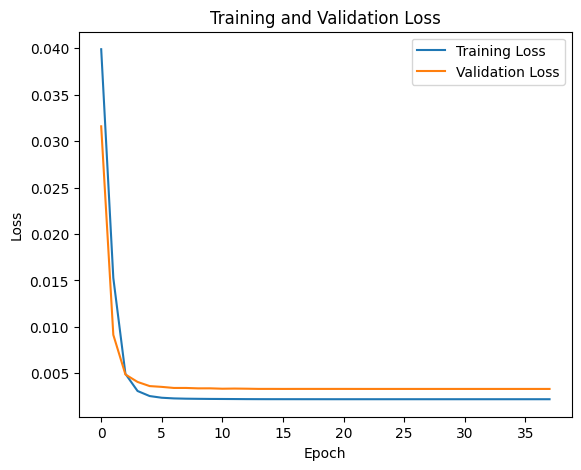

In [ ]:
history = model.history.history

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()

Now, let's generate the evaluation metrics for the dimensions 44x15, 15x15, and the 110 coordinates.

In [ ]:
train_prediction = model.predict(x_train_flattened)

train_prediction_reshaped = train_prediction.reshape(-1, 15)
train_prediction_original_scale = scaler.inverse_transform(train_prediction_reshaped)
train_prediction_original_scale = train_prediction_original_scale.reshape(-1, 44, 15)

y_train_reshaped = y_train.reshape(-1, 15)
y_train_original_scale = scaler.inverse_transform(y_train_reshaped)
y_train_original_scale = y_train_original_scale.reshape(-1, 44, 15)

val_prediction = model.predict(x_val_flattened)

val_prediction_reshaped = val_prediction.reshape(-1, 15)
val_prediction_original_scale = scaler.inverse_transform(val_prediction_reshaped)
val_prediction_original_scale = val_prediction_original_scale.reshape(-1, 44, 15)

y_val_reshaped = y_val.reshape(-1, 15)
y_val_original_scale = scaler.inverse_transform(y_val_reshaped)
y_val_original_scale = y_val_original_scale.reshape(-1, 44, 15)

test_prediction = model.predict(x_test_flattened)

test_prediction_reshaped = test_prediction.reshape(-1, 15)
test_prediction_original_scale = scaler.inverse_transform(test_prediction_reshaped)
test_prediction_original_scale = test_prediction_original_scale.reshape(-1, 44, 15)

y_test_reshaped = y_test.reshape(-1, 15)
y_test_original_scale = scaler.inverse_transform(y_test_reshaped)
y_test_original_scale = y_test_original_scale.reshape(-1, 44, 15)

4/4 [==============================] - 0s 11ms/step


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def calcular_metricas_3d(original_tensor, prediccion_tensor):

    sum_mae, sum_mse, sum_rmse, sum_r2 = 0, 0, 0, 0

    for i in range(original_tensor.shape[0]):
        mae = mean_absolute_error(original_tensor[i], prediccion_tensor[i])
        mse = mean_squared_error(original_tensor[i], prediccion_tensor[i])
        rmse = np.sqrt(mse)
        r2 = r2_score(original_tensor[i].flatten(), prediccion_tensor[i].flatten())

        sum_mae += mae
        sum_mse += mse
        sum_rmse += rmse
        sum_r2 += r2

    avg_mae = sum_mae / original_tensor.shape[0]
    avg_mse = sum_mse / original_tensor.shape[0]
    avg_rmse = sum_rmse / original_tensor.shape[0]
    avg_r2 = sum_r2 / original_tensor.shape[0]

    return avg_mae, avg_mse, avg_rmse, avg_r2

Metrics for 44x15

In [ ]:
mae, mse, rmse, r2 = calcular_metricas_3d(y_train_original_scale, train_prediction_original_scale)

print("Training:")
print(f"Average MAE: {mae:.3f}")
print(f"Average MSE: {mse:.3f}")
print(f"Average RMSE: {rmse:.3f}")
print(f"Average R^2: {r2:.3f}")
print("")

mae, mse, rmse, r2 = calcular_metricas_3d(y_val_original_scale, val_prediction_original_scale)

print("Validation:")
print(f"Average MAE: {mae:.3f}")
print(f"Average MSE: {mse:.3f}")
print(f"Average RMSE: {rmse:.3f}")
print(f"Average R^2: {r2:.3f}")
print("")

mae, mse, rmse, r2 = calcular_metricas_3d(y_test_original_scale, test_prediction_original_scale)

print("Test:")
print(f"Average MAE: {mae:.3f}")
print(f"Average MSE: {mse:.3f}")
print(f"Average RMSE: {rmse:.3f}")
print(f"Average R^2: {r2:.3f}")
print("")

Training:
Average MAE: 1.729
Average MSE: 15.585
Average RMSE: 3.876
Average R^2: 0.914

Validation:
Average MAE: 2.240
Average MSE: 22.599
Average RMSE: 4.692
Average R^2: 0.901

Test:
Average MAE: 2.308
Average MSE: 22.871
Average RMSE: 4.738
Average R^2: 0.899



Metrics for 15x15

In [ ]:
def postprocess(arr):
  unshifted_matrix = np.empty_like(arr)
  for i in range(arr.shape[1]):
      n = i
      unshifted_matrix[:, i] = np.concatenate((arr[-n:, i], arr[:-n, i]))

  unpadded_matrix = unshifted_matrix[14:, :]
  downsampled_matrix = unpadded_matrix[::2]

  return downsampled_matrix

# Training:
# Postprocess originals
postprocessed_originals_train = []
for i in range(y_train_original_scale.shape[0]):
    postprocessed_matrix = postprocess(y_train_original_scale[i])
    postprocessed_originals_train.append(postprocessed_matrix)
postprocessed_original_arr_train = np.array(postprocessed_originals_train)

# Postprocess predictions
postprocessed_predictions_train = []
for i in range(train_prediction_original_scale.shape[0]):
    postprocessed_matrix = postprocess(train_prediction_original_scale[i])
    postprocessed_predictions_train.append(postprocessed_matrix)

postprocessed_predictions_arr_train = np.array(postprocessed_predictions_train)

# Validation:
# Postprocess originals
postprocessed_originals_val = []
for i in range(y_val_original_scale.shape[0]):
    postprocessed_matrix = postprocess(y_val_original_scale[i])
    postprocessed_originals_val.append(postprocessed_matrix)
postprocessed_original_arr_val = np.array(postprocessed_originals_val)

# Postprocess predictions
postprocessed_predictions_val = []
for i in range(val_prediction_original_scale.shape[0]):
    postprocessed_matrix = postprocess(val_prediction_original_scale[i])
    postprocessed_predictions_val.append(postprocessed_matrix)

postprocessed_predictions_arr_val = np.array(postprocessed_predictions_val)

# Testing:
# Postprocess originals
postprocessed_originals_test = []
for i in range(y_test_original_scale.shape[0]):
    postprocessed_matrix = postprocess(y_test_original_scale[i])
    postprocessed_originals_test.append(postprocessed_matrix)
postprocessed_original_arr_test = np.array(postprocessed_originals_test)

# Postprocess predictions
postprocessed_predictions_test = []
for i in range(test_prediction_original_scale.shape[0]):
    postprocessed_matrix = postprocess(test_prediction_original_scale[i])
    postprocessed_predictions_test.append(postprocessed_matrix)

postprocessed_predictions_arr_test = np.array(postprocessed_predictions_test)

# Calcular las métricas promedio
mae, mse, rmse, r2 = calcular_metricas_3d(postprocessed_original_arr_train, postprocessed_predictions_arr_train)

print("Training:")
print(f"Average MAE: {mae:.3f}")
print(f"Average MSE: {mse:.3f}")
print(f"Average RMSE: {rmse:.3f}")
print(f"Average R^2: {r2:.3f}")
print("")

mae, mse, rmse, r2 = calcular_metricas_3d(postprocessed_original_arr_val, postprocessed_predictions_arr_val)

print("Validation:")
print(f"Average MAE: {mae:.3f}")
print(f"Average MSE: {mse:.3f}")
print(f"Average RMSE: {rmse:.3f}")
print(f"Average R^2: {r2:.3f}")
print("")

mae, mse, rmse, r2 = calcular_metricas_3d(postprocessed_original_arr_test, postprocessed_predictions_arr_test)

print("Test:")
print(f"Average MAE: {mae:.3f}")
print(f"Average MSE: {mse:.3f}")
print(f"Average RMSE: {rmse:.3f}")
print(f"Average R^2: {r2:.3f}")
print("")

Training:
Average MAE: 2.362
Average MSE: 22.679
Average RMSE: 4.675
Average R^2: 0.893

Validation:
Average MAE: 3.040
Average MSE: 32.784
Average RMSE: 5.653
Average R^2: 0.877

Test:
Average MAE: 3.142
Average MSE: 33.217
Average RMSE: 5.711
Average R^2: 0.875



Metrics for 110 coordinates

In [ ]:
# We convert the data into dataframes and combine actual vs. predictions
def array_to_dataframe(arr):
    ids = []
    is_list = []
    js_list = []
    velocidades = []

    for id in range(arr.shape[0]):
        for i in range(arr.shape[1]):
            for j in range(arr.shape[2]):
                ids.append(id)
                is_list.append(i)
                js_list.append(j)
                velocidades.append(arr[id, i, j])

    df = pd.DataFrame({
        'id': ids,
        'i': is_list,
        'j': js_list,
        'speed': velocidades
    })

    return df

# Training:
df_actuals_train = array_to_dataframe(postprocessed_original_arr_train)
df_preds_train = array_to_dataframe(postprocessed_predictions_arr_train)

df_original_train = df_actuals_train.rename(columns={'speed': 'speed_actual'})
df_predictions_train = df_preds_train.rename(columns={'speed': 'speed_predicted'})

df_results_train = pd.merge(df_original_train, df_predictions_train, on=['id','i', 'j'], how='inner')
# ----------------------------#

# Validation:
df_actuals_val = array_to_dataframe(postprocessed_original_arr_val)
df_preds_val = array_to_dataframe(postprocessed_predictions_arr_val)

df_original_val = df_actuals_val.rename(columns={'speed': 'speed_actual'})
df_predictions_val = df_preds_val.rename(columns={'speed': 'speed_predicted'})

df_results_val = pd.merge(df_original_val, df_predictions_val, on=['id','i', 'j'], how='inner')
# ----------------------------#

# Test:
df_actuals_test = array_to_dataframe(postprocessed_original_arr_test)
df_preds_test = array_to_dataframe(postprocessed_predictions_arr_test)

df_original_test = df_actuals_test.rename(columns={'speed': 'speed_actual'})
df_predictions_test = df_preds_test.rename(columns={'speed': 'speed_predicted'})

df_results_test = pd.merge(df_original_test, df_predictions_test, on=['id','i', 'j'], how='inner')
# ----------------------------#


results_110_train = pd.merge(ori_coords, df_results_train, on=['i','j'])
results_110_val = pd.merge(ori_coords, df_results_val, on=['i','j'])
results_110_test = pd.merge(ori_coords, df_results_test, on=['i','j'])

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt

def calculate_metrics(df):
    y_true = df['speed_actual']
    y_pred = df['speed_predicted']

    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    smape = 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))
    maaape = np.mean(np.arctan(np.abs((y_true - y_pred) / y_true))) * 100

    return mae, mse, rmse, r2, mape, smape, maaape


mae, mse, rmse, r2, mape, smape, maaape = calculate_metrics(results_110_train)

print("Training:")
print("----------")
print(f"Average MAE: {mae:.3f}")
print(f"Average MSE: {mse:.3f}")
print(f"Average RMSE: {rmse:.3f}")
print(f"Average R^2: {r2:.3f}")
print(f"Average MAPE: {mape:.3f}")
print(f"Average SMAPE: {smape:.3f}")
print(f"Average MAAPE: {maaape:.3f}")
print("")

mae, mse, rmse, r2, mape, smape, maaape = calculate_metrics(results_110_val)

print("Validation:")
print("----------")
print(f"Average MAE: {mae:.3f}")
print(f"Average MSE: {mse:.3f}")
print(f"Average RMSE: {rmse:.3f}")
print(f"Average R^2: {r2:.3f}")
print(f"Average MAPE: {mape:.3f}")
print(f"Average SMAPE: {smape:.3f}")
print(f"Average MAAPE: {maaape:.3f}")
print("")

mae, mse, rmse, r2, mape, smape, maaape = calculate_metrics(results_110_test)

print("Testing:")
print("----------")
print(f"Average MAE: {mae:.3f}")
print(f"Average MSE: {mse:.3f}")
print(f"Average RMSE: {rmse:.3f}")
print(f"Average R^2: {r2:.3f}")
print(f"Average MAPE: {mape:.3f}")
print(f"Average SMAPE: {smape:.3f}")
print(f"Average MAAPE: {maaape:.3f}")
print("")

Training:
----------
Average MAE: 4.334
Average MSE: 45.276
Average RMSE: 6.729
Average R^2: 0.634
Average MAPE: inf
Average SMAPE: 36.101
Average MAAPE: 32.145

Validation:
----------
Average MAE: 5.471
Average MSE: 65.050
Average RMSE: 8.065
Average R^2: 0.600
Average MAPE: inf
Average SMAPE: 38.576
Average MAAPE: 34.132

Testing:
----------
Average MAE: 5.610
Average MSE: 65.615
Average RMSE: 8.100
Average R^2: 0.602
Average MAPE: inf
Average SMAPE: 39.172
Average MAAPE: 34.794

